## Libraries and packages

In [1]:
from Bio import Entrez
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
# nltk.download()
from gensim.models import word2vec
from sklearn.manifold import TSNE

email = 'Your Email'

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


____________________________________________________________________________________

## Code

### Improved analysis

#### Expanding the dataset

Dataset size was improved by modifying the get_articles_info() function. The majority of failed fetches were due to an IndexError on the 'Year' path.

In [3]:
# merging the first dataset and the later into one
df_autism_articles_v1 = pd.read_csv('AutismArticlesRaw.csv')
df_autism_articles_v2 = pd.read_csv('AutismArticlesRaw_Error.csv')
df_autism_articles = pd.concat([df_autism_articles_v1, df_autism_articles_v2])

# drops missing values
df_autism_articles.dropna(inplace=True)

# sort by year
df_autism_articles.sort_values('Year', ascending=False, inplace=True)

# update index
index = pd.Series([i for i in range (0, len(df_autism_articles))])
df_autism_articles.index = index

df_autism_articles.to_csv('AutismArticlesRaw_v2.csv', encoding='utf-8', index=False)

df_autism_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37518 entries, 0 to 37517
Data columns (total 4 columns):
Abstract    37518 non-null object
Id          37518 non-null int64
Title       37518 non-null object
Year        37518 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


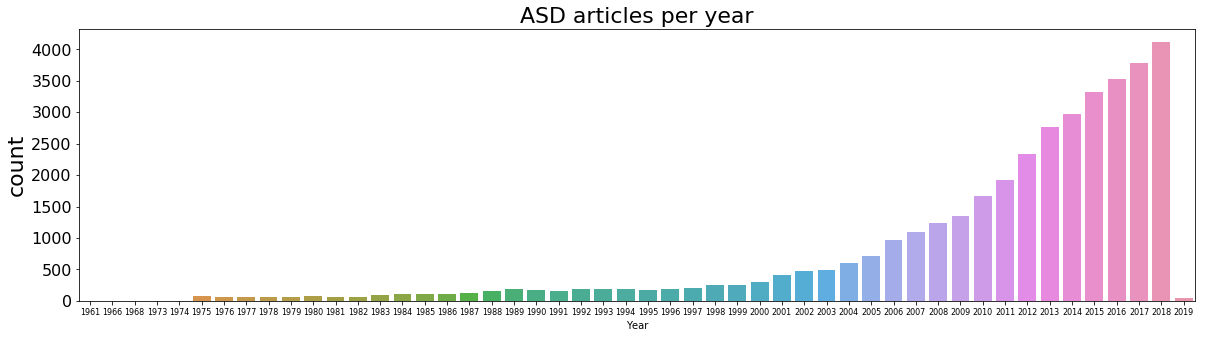

In [15]:
df_autism_articles = pd.read_csv('AutismArticlesRaw_v2.csv')
plt.figure(figsize=(20,5))
plt.xticks(fontsize=8)
plt.yticks(fontsize=16)
plt.ylabel('count', fontsize=22)
plt.title('ASD articles per year', fontsize=22)
sns.countplot(x='Year', data=df_autism_articles)

#### Abstract data preprocessing

In [23]:
# creates a new column in the dataframe for the preprocessed data
preprocessed = pd.Series()
df_autism_articles.insert(loc=1, column='Preprocessed', value=preprocessed)

# replaces with space anything that isn't a lower case or upper case letter
df_autism_articles['Preprocessed'] = df_autism_articles['Abstract'].replace(
    r'[^a-zA-Z]', " ", regex=True)

# replaces multiple spaces with single space
df_autism_articles['Preprocessed'] = df_autism_articles[
    'Preprocessed'].replace(
        r' +', " ", regex=True)

# converts everything to lower case
df_autism_articles['Preprocessed'] = df_autism_articles[
    'Preprocessed'].str.lower()

# removes stop words
stop_words = set(stopwords.words("english"))
df_autism_articles['Preprocessed'] = df_autism_articles['Preprocessed'].apply(lambda abstract: 
                                                                              [word for word in str(abstract).split() 
                                                                               if word not in stop_words])

# word stemming
df_autism_articles['Preprocessed'] = df_autism_articles['Preprocessed'].apply(lambda abstract: 
                                                                              [stemmer.stem(word) for word in abstract])

# joins the words into one string to be stored in the dataframe
df_autism_articles['Preprocessed'] = df_autism_articles['Preprocessed'].str.join(' ')

# drops missing values
df_autism_articles.dropna(inplace=True)

# saves the dataframe to .csv file
df_autism_articles.to_csv('PreProcessedAbstracts_v2.csv', encoding='utf-8', index=False)

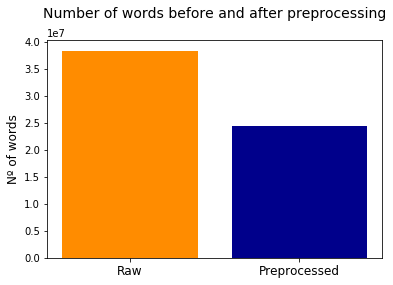

In [6]:
total_word_count = 0
for abstract in df_autism_articles['Abstract']:
    total_word_count = total_word_count + len(abstract)
    
# word count after preprocessing
cleaned_word_count = 0
for abstract in df_autism_articles['Preprocessed']:
    cleaned_word_count = cleaned_word_count + len(abstract)
    
plt.bar([0,1], [total_word_count, cleaned_word_count], color=['darkorange', 'darkblue'])
plt.ylabel('Nº of words', fontsize=12)
plt.xticks([0,1], ['Raw','Preprocessed'], fontsize=12)
plt.title('Number of words before and after preprocessing\n', fontsize=14)
plt.show()

#### word2vec model

In [4]:
df_autism_articles = pd.read_csv('PreProcessedAbstracts_v2.csv')
df_autism_articles.dropna(inplace=True)

In [24]:
df_autism_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37518 entries, 0 to 37517
Data columns (total 5 columns):
Abstract        37518 non-null object
Preprocessed    37518 non-null object
Id              37518 non-null int64
Title           37518 non-null object
Year            37518 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.7+ MB


In [5]:
# builds the corpus for the word2vec model
corpus = [abstract_word_list.split(' ') for abstract_word_list in df_autism_articles['Preprocessed']]

# runs the model
# size = number of neurons
# window = maximum distance between the current and predicted word
# min_count =  ignore all words with counts lower than this threshold
# workers = number of threads used to train the model

model = word2vec.Word2Vec(corpus, size=300, window=5, min_count=1000, workers=4)
model.train(corpus, total_examples=len(corpus), epochs=10)
model_name = "model_s300_w5_min1000_stemm_train"
model.save(model_name)

print('A total of {} words were used to train the model.'.format(len(model.wv.vocab)))

A total of 693 words were used to train the model.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


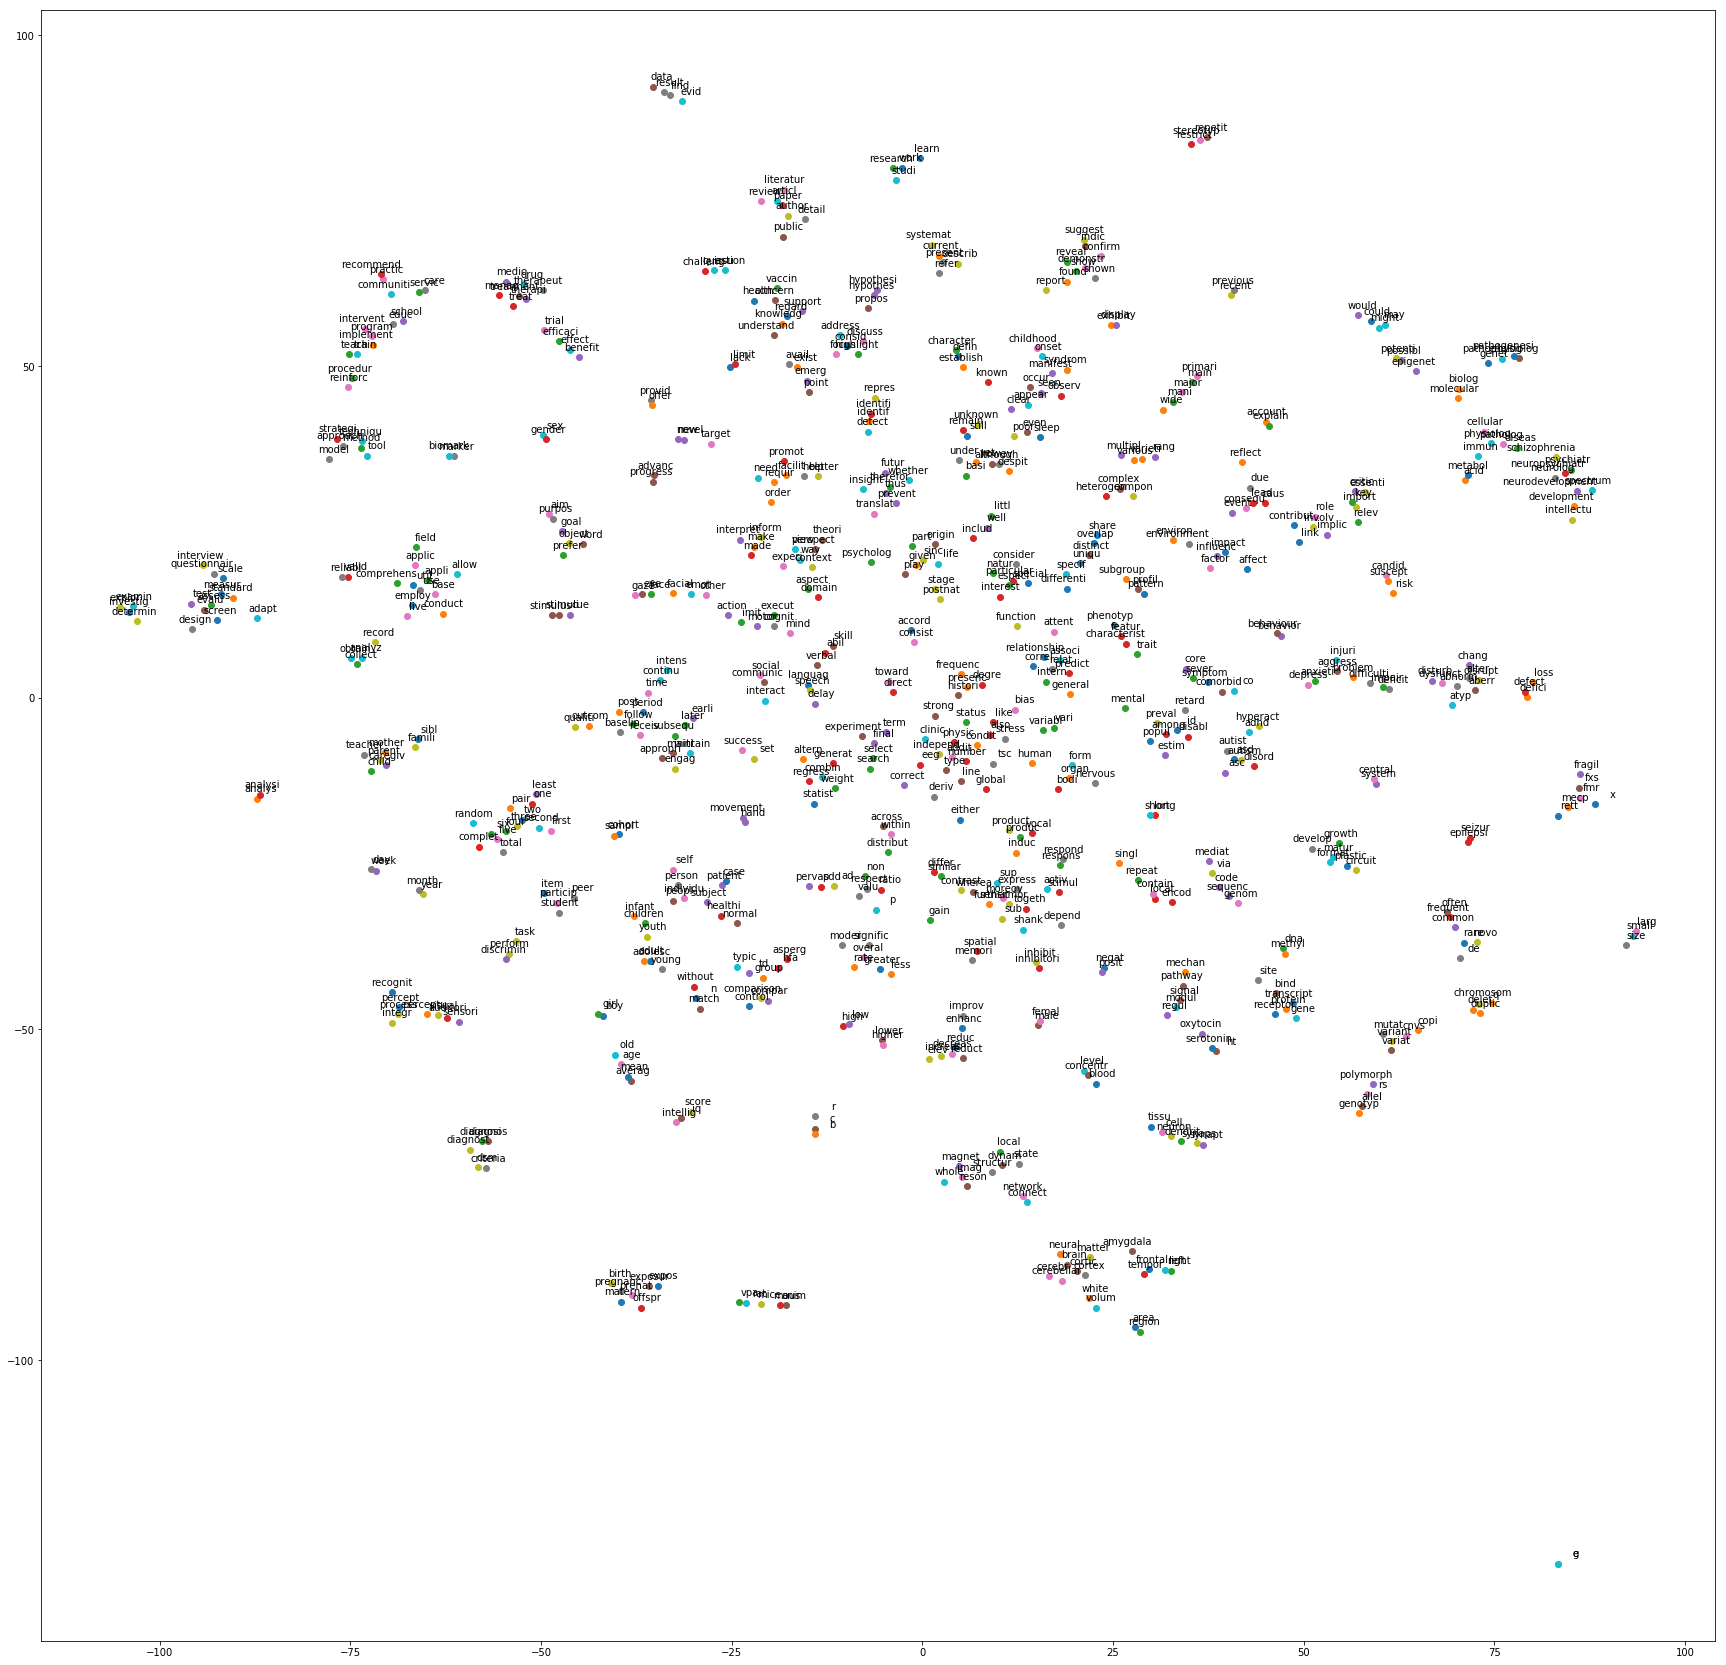

In [26]:
# t-SNE dimension reduction model

labels = []
tokens = []

for word in model.wv.vocab:
    tokens.append(model[word])
    labels.append(word)

tsne_model = TSNE(perplexity=4, n_components=2, init='pca', n_iter=2500)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(30, 30)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(20, 5),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.savefig('model_tsne.png', bbox_inches='tight', dpi=300)
plt.show()

### Conclusions
- The Word2Vec neural network is a excellent tool for natural language processing. It's concept is easy to understand and you can find really great examples and tutorials on the Internet to start your own analysis.
<br>
<br>
- About the t-SNE plot of the results, there are some interesting clusters we can observe:
<br>
<br>
  - Some words used as synonyms in scientific literature grouped together, like: 
    - data, result, find(ings), evid(ence);
    - key, import(ant), critic, essenti(al);
    - improv(ement), enhanc(ement), increase, elev(ation), reduct(ion), decrease;
<br>
<br>
  - ASD core symptoms and comorbidities:
    - repetit(ive), stereotyp(ical), restrict(ed);
    - social, communic(ation), interact(ion);
    - verbal, language, speech, delay;
    - aggress(ive), anxiety, depress(ion), injuries
<br>
<br>
  - Other conditions linked to increased risk for ASD, such as Fragile X Syndrome and Rett Syndrome:
    - fragil(e), fxs, fmrx, mecp(2), rett;
<br>
<br>
  - Central Nervous System areas and related terms:
    - cortex, matter, cortic(al), brain, cerebellar, neural, amygdala;
<br>
<br>
  - Genetics and related terms:
    - genotyp(e), allel(e), polymorph(ism), mutat(ion), delet(ion), duplic(ation);
<br>
<br>
- There are many more interesting ones, some of them you have to be familiar with this area to fully understand the word relationships.